# PyCuda Practical session: convolution
## 2D Convolution example

Convolution operations are essential to signal and image processing
applications and are the main operation in convolutional neural networks used for
deep learning.
A convolution operation computes the linear combination of the
weights in a *convolution filter* and a range of pixels from the input
image for each output pixel. A 2D convolution of an input image $I$ of size
$(w\times h)$ and a convolution filter $F$ of size $(F_w\times F_h)$ computes
an output image $O$ of size $((w-F_w)\times (h-F_h))$:
\begin{equation}\nonumber
O(x,y) = \sum\limits_{j=0}^{F_h} \sum\limits_{i=0}^{F_w} I(x+i,y+j)\times F(i,j)
\end{equation}

Said in other words, it consists in computing locally (to a patch of the size of the filter) a linear combination of the pixels in the image. 

## 2D convolutions implemented in Numpy
Here is an exemple of how a convolution is written in numpy


In [1]:
import numpy as np


def np_convolve(a, b):
    
    image, kernel = [np.array(i).astype(np.float32) for i in [a, b]]
    
    # Sum of absolute values in kernel matrix
    kernel_sum = np.absolute(kernel).sum()
    
    # Calculate the dimensions for iteration over the pixels and weights
    i_width, i_height = image.shape[1], image.shape[0]
    k_width, k_height = kernel.shape[1], kernel.shape[0]

    if k_width % 2 == 0 or k_height % 2 == 0:
        print("Warning: Kernel dimensions not odd. Centre point ambiguous, could break code.")
    
    padding_w = k_width-1
    padding_h = k_height-1
    
    f_width = i_width - padding_w
    f_height = i_height - padding_h
    
    # Prepare the output array
    filtered = np.zeros((f_height, f_width))
    
    # Iterate over image
    for y in range(f_height):
        for x in range(f_width):
            
            weighted_pixel_sum = 0  # Initial pixel value
    
            # Iterate over kernel
            for ky in range(-int(padding_h/2), int(padding_h/2)+1):
                for kx in range(-int(padding_w/2), int(padding_w/2)+1):
                    
                    # Coordinates of pixel on original image (for each kernel element)
                    pixel_y = int(y - ky + padding_h/2)
                    pixel_x = int(x - kx + padding_w/2)
        
                    # Set value of pixel based on coordinates
                    pixel = image[pixel_y, pixel_x] 

                    # Get weight of this pixel from kernel matrix
                    weight = kernel[ky + int(k_height / 2), kx + int(k_width / 2)]
    
                    # Weigh the pixel value and sum, update pixel value for this image coordinate
                    weighted_pixel_sum += pixel * weight
    
            # Set pixel at location (x,y) in output to sum of the weighed neighborhood
            filtered[y, x] = weighted_pixel_sum / kernel_sum
    
    return filtered

## 2D convolution in PyCuda

We now look at the equivalent version in PyCuda. First we need to install it on our environment.


In [ ]:
!pip install pycuda

Then here is also how we can implement it efficiently in Pycuda

In [3]:
import numpy as np

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule


cuda_convolve_kernel = """__global__ void conv(const float *A, const float *B, int aw, int ah, int bw, int bh, int b_sum, float *C){

    /*Get row and column to operate on from thread coordinates*/
    int tx = threadIdx.x;
    int ty = threadIdx.y;
    
    int bx = blockIdx.x;
    int by = blockIdx.y;
    
    int row = by*blockDim.y + ty;
    int col = bx*blockDim.x + tx;
    
    /*Calculate "padding" radius of convolution kernel (distance around central pixel)*/
    int pw = (bw-1)/2;
    int ph = (bh-1)/2;

    /*If within the range of C (ie A - padding)*/
    if( row < (ah-2*ph) && col < (aw-2*pw) ) {
        
        /*Set initial pixel value*/
        int val = 0;
        
         /*For each vertical position on the kernel matrix, relative to the central pixel*/
        for(int i=-ph; i<=ph; i=i+1){
            /*Calculate zero-indexed row ID on kernel matrix*/
            int b_row = i+ph; 

            /*For each horizontal position on the kernel matrix, relative to the central pixel*/
            for(int j=-pw; j<=pw; j=j+1){
                /*Calculate zero-indexed column ID on kernel matrix*/
                int b_col = j+pw;

                /*Add product of kernel value and corresponding image value to running total*/
                val += A[ (row+ph +i)*aw + (col+pw +j) ] * B[ b_row*bw + b_col ];
            }
        }
        
        /*Copy appropriately normalised resulting pixel value to position on C matrix*/
        C[row*(aw-2*pw) + col] = val/b_sum;
    }
}"""


# DEVICE SETUP
BLOCK_SIZE = 32  # Max 32. 32**2 = 1024, max for GTX1060
    
# Compile kernel
mod = SourceModule(cuda_convolve_kernel)

# Get functions
conv = mod.get_function("conv")


def cu_convolve(a, b):
    global BLOCK_SIZE
    global conv
    
    a, b = [np.array(i).astype(np.float32) for i in [a, b]]
    
    # Matrix A 
    aw = np.int32(a.shape[1])  # Widthof in matrix
    ah = np.int32(a.shape[0])  # Height of in matrix
    
    # Matrix B (kernel)
    bw = np.int32(b.shape[1])  # Widthof in matrix
    if bw % 2 == 0:
        print("Kernel width is not an odd number! Strange things will happen...")
    bh = np.int32(b.shape[0])  # Height of in matrix
    if bh % 2 == 0:
        print("Kernel height is not an odd number! Strange things will happen...")
    b_sum = np.int32(np.absolute(b).sum())
    
    # Matrix C, subtract 2*padding, *2 because it's taken off all sides
    c = np.empty([ah-(bh-1), aw-(bw-1)])
    c = c.astype(np.float32)
    
    # Allocate memory on device
    a_gpu = cuda.mem_alloc(a.nbytes)
    b_gpu = cuda.mem_alloc(b.nbytes)
    c_gpu = cuda.mem_alloc(c.nbytes)
    
    # Copy matrix to memory
    cuda.memcpy_htod(a_gpu, a)
    cuda.memcpy_htod(b_gpu, b)

    # Set grid size from A matrix
    grid = (int(aw/BLOCK_SIZE+(0 if aw % BLOCK_SIZE is 0 else 1)), 
            int(ah/BLOCK_SIZE+(0 if ah % BLOCK_SIZE is 0 else 1)), 
                          1)
    
    # Call gpu function
    conv(a_gpu, b_gpu, aw, ah, bw, bh, b_sum, c_gpu, block=(BLOCK_SIZE, BLOCK_SIZE, 1), grid=grid)
    
    # Copy back the result
    cuda.memcpy_dtoh(c, c_gpu)
    
    # Free memory. May not be useful? Ask about this.
    a_gpu.free()
    b_gpu.free()
    c_gpu.free()
    
    # Return the result
    return c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



## Let's test it on a sample grayscale image

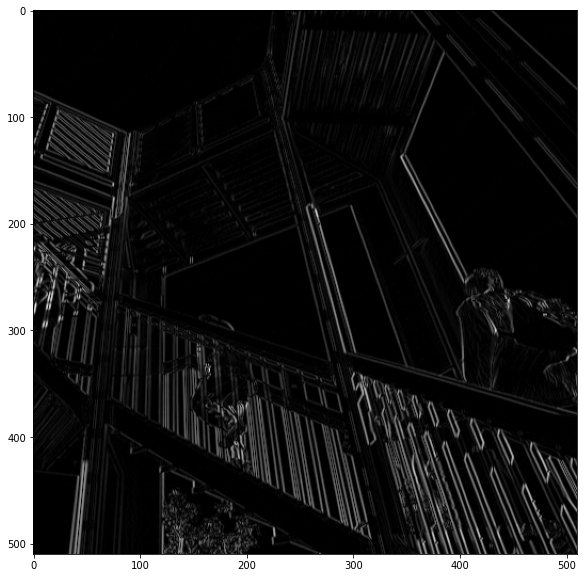

GPU time: 0.00392 s


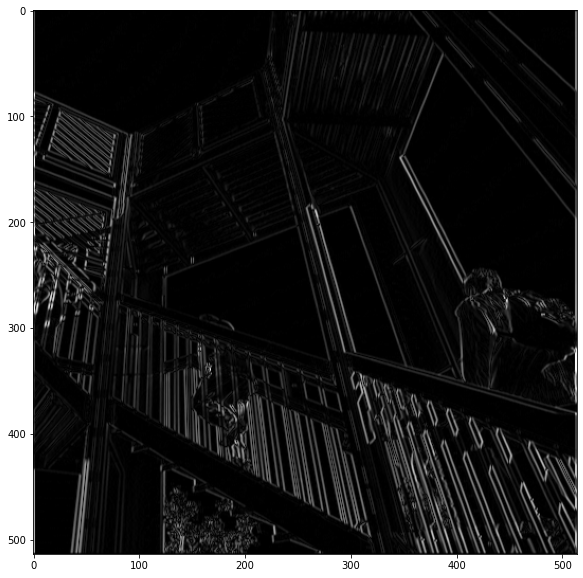

Scipy time: 0.02718 s
CPU time: 5.69196 s


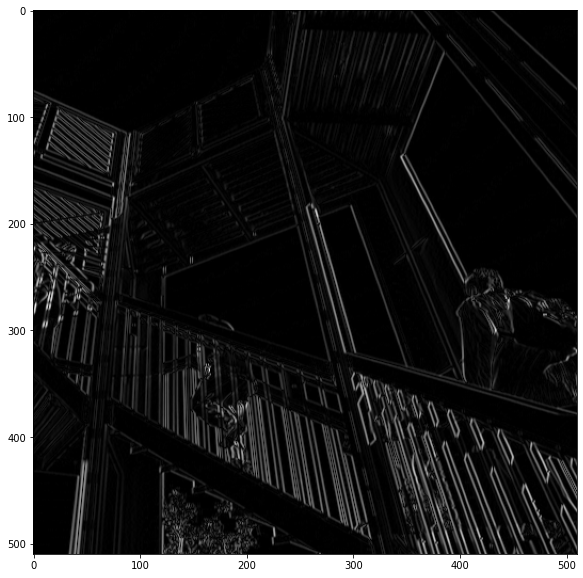

In [5]:
import numpy as np
from scipy import misc
import time

from scipy import signal as sg

from scipy import misc
f = misc.ascent()
f_shape = f.shape

import matplotlib.pyplot as plt

def plotImage(f):
  plt.figure(figsize=(10,10))
  plt.gray()
  plt.imshow(f)
  plt.show()


# Write numpy array to image
def to_img(m):
    return np.clip(np.absolute(m), 0, 255)



# Normalize kernel matrix
def nrm(m):
    m = np.array(m)
    return m/np.sum(np.abs(m))


# CREATE KERNELS
k_sv = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]] # this filter acts as a vertical line detector
k_sh = [[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]] # this filter acts as a horizontal line detector

# LOAD IMAGE
a = f.astype(np.float32)


# GPU
start = time.time()
c = cu_convolve(a, k_sv)
end = time.time()
plotImage(to_img(c))
print("GPU time: %.5f s" % (end-start))

# SCIPY
start = time.time()
c = sg.convolve(a, nrm(k_sv))
end = time.time()
plotImage(to_img(c))

print("Scipy time: %.5f s" % (end-start))

# CPU
start = time.time()
c = np_convolve(a, k_sv)
end = time.time()
print("CPU time: %.5f s" % (end-start))
plotImage(to_img(c))


you can appreciate the differences in execution timings

# Practical work

Now, what if we are working with an image that has several color/spectral channels ? First we will consider as a basis the hyperspectral image studied previously in the warm-up session. 

We are going to load this image.

In [ ]:
import scipy.io as scio
import pylab as pl
import numpy as np

image = scio.loadmat('Urban_R162.mat')
nRow = int(image['nRow'])
nCol = int(image['nCol']) 
nBand = 162
Y = np.array(image['Y'],dtype=float)
Y=Y.reshape((nBand,nRow,nCol))/image['maxValue']

Y=np.swapaxes(Y,0,1)
Y=np.swapaxes(Y,1,2)

pl.figure()
pl.imshow(Y[:,:,[50,100,150]])
pl.show()

write a code that performs sequnetially the filtering of all the spectral bands, annd display the image


Is it possible to adapt the pycuda kernel to have a faster version for this convolution ? Try to write your own, and compare the performances with the previous version that you wrote


Finally, try different sizes of grid / blocks to how it impacts performances.
